In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
from scipy.sparse.linalg import svds

In [2]:
df = pd.read_csv('ratings.csv')

In [3]:
df.shape

(100000, 3)

In [4]:
user_item_matrix = df.pivot(index='userId', columns='movieId', values='rating')

In [5]:
user_item_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,1673,1674,1675,1676,1677,1678,1679,1680,1681,1682
userId,,,,,,,,,,,,,,,,,,,,,
1,5.0,3.0,4.0,3.0,3.0,5.0,4.0,1.0,5.0,3.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
940,NaN,NaN,NaN,2.0,NaN,NaN,4.0,5.0,3.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
941,5.0,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
def truncated_svd(A, k=20):
    # Step 1: Compute A^T A
    ATA = A.T @ A
    
    # Step 2: Eigen decomposition of A^T A
    eigvals, eigvecs = np.linalg.eigh(ATA)
    
    # Step 3: Sort eigenvalues and eigenvectors by descending order
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx][:k]
    V = eigvecs[:, idx][:, :k]
    
    # Step 4: Compute singular values (sqrt of eigenvalues)
    singular_vals = np.sqrt(np.abs(eigvals))
    Sigma = np.diag(singular_vals)
    
    # Step 5: Compute U = A V Σ⁻¹
    U = A @ V @ np.linalg.inv(Sigma)
    
    return U, Sigma, V.T

In [9]:
def matrix_completion(R,k=20):
    R = R.values
    isnan = np.isnan(R)

    # Compute user means only on non-NaNs
    user_mean = np.nanmean(R, axis=1) # mean of each row separately
    R_demeaned = R - user_mean.reshape(-1, 1)
    R_demeaned[isnan] = 0  # Replace NaNs with zero for SVD
    
    # Sparse SVD
    U, Sigma, Vt = truncated_svd(R_demeaned, k=k)
    R_pred = U @ Sigma @ Vt + user_mean.reshape(-1, 1)
    return R_pred


In [10]:
svd_pred = matrix_completion(user_item_matrix,k = 200)

In [11]:
def compute_svd_rmse(svd_pred,org_matrix):
    return np.sqrt(mean_squared_error(org_matrix.values[org_matrix.values > 0], svd_pred[org_matrix.values > 0]))

In [12]:
svd_rmse = compute_svd_rmse(svd_pred,user_item_matrix)
print(f"SVD RMSE: {svd_rmse:.4f}")

SVD RMSE: 0.3692


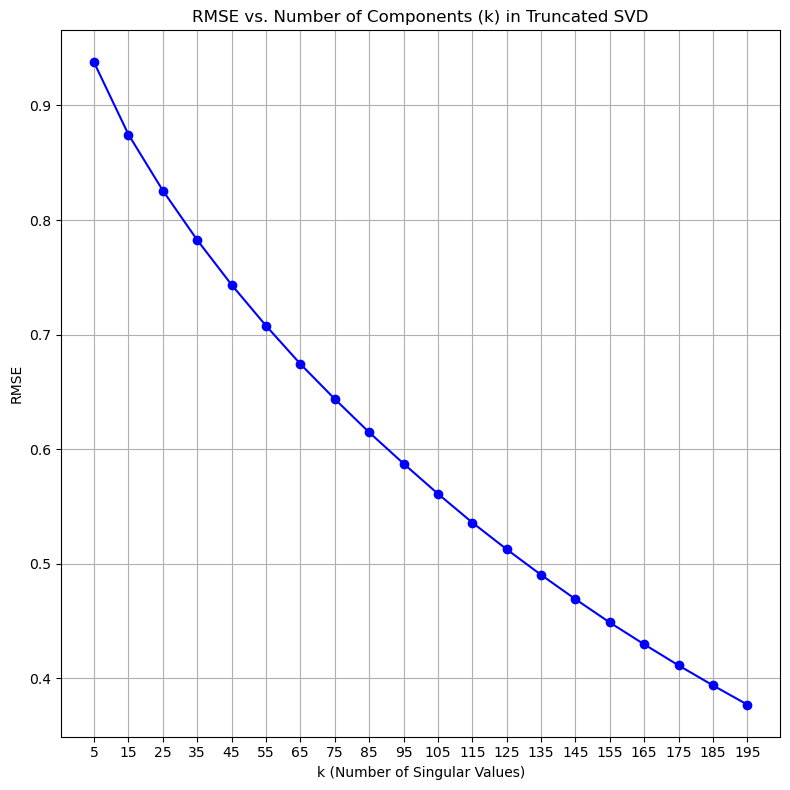

In [13]:
rmse_scores = []
k_values = [i for i in range(5,201,10)]
for k in k_values:
    svd_pred = matrix_completion(user_item_matrix,k=k)
    svd_rmse = compute_svd_rmse(svd_pred,user_item_matrix)
    rmse_scores.append(svd_rmse)


plt.figure(figsize=(8, 8))
plt.plot(k_values, rmse_scores, marker='o', linestyle='-', color='blue')
plt.title('RMSE vs. Number of Components (k) in Truncated SVD')
plt.xlabel('k (Number of Singular Values)')
plt.ylabel('RMSE')
plt.grid(True)
plt.xticks(k_values)
plt.tight_layout()
plt.show()

We observe that the RMSE decreases as we increase the number of singular values in the SVD computation. This will saturate to a particular value and will give diminishing returns.

In [14]:
svd_pred = matrix_completion(user_item_matrix,k=10)

In [15]:
svd_rmse = compute_svd_rmse(svd_pred ,user_item_matrix)
print(svd_rmse)

0.9026510415760938


In [16]:
print(user_item_matrix.values[:10,:10])

[[ 5.  3.  4.  3.  3.  5.  4.  1.  5.  3.]
 [ 4. nan nan nan nan nan nan nan nan  2.]
 [nan nan nan nan nan nan nan nan nan nan]
 [nan nan nan nan nan nan nan nan nan nan]
 [ 4.  3. nan nan nan nan nan nan nan nan]
 [ 4. nan nan nan nan nan  2.  4.  4. nan]
 [nan nan nan  5. nan nan  5.  5.  5.  4.]
 [nan nan nan nan nan nan  3. nan nan nan]
 [nan nan nan nan nan  5.  4. nan nan nan]
 [ 4. nan nan  4. nan nan  4. nan  4. nan]]


In [18]:
print(svd_pred[:10,:10].round(0))

[[4. 4. 3. 4. 3. 4. 5. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 3. 3. 3. 3. 3.]
 [4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
 [3. 3. 3. 3. 3. 3. 4. 3. 2. 3.]
 [3. 3. 4. 3. 4. 4. 4. 4. 4. 4.]
 [3. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
 [4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]]


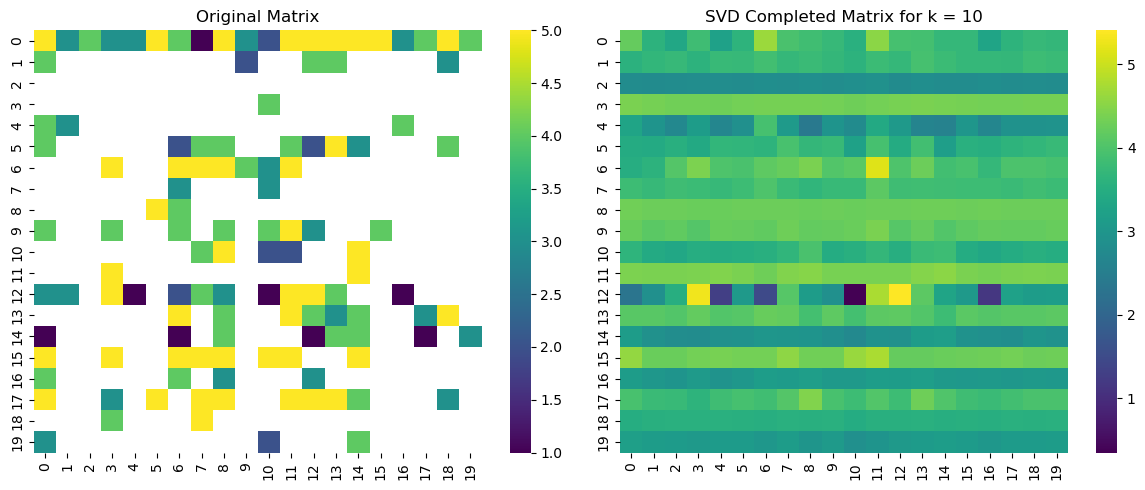

In [19]:
# Heatmaps for Comparison between Original and SVD completed Matrix
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(user_item_matrix.values[:20, :20], cmap='viridis')
plt.title("Original Matrix")

plt.subplot(1, 2, 2)
sns.heatmap(svd_pred[:20, :20], cmap='viridis')
plt.title("SVD Completed Matrix for k = 10")
plt.tight_layout()
plt.show()

In [20]:
svd_pred = matrix_completion(user_item_matrix,k=50)
svd_rmse = compute_svd_rmse(svd_pred ,user_item_matrix)
print(svd_rmse)


0.7252905064262314


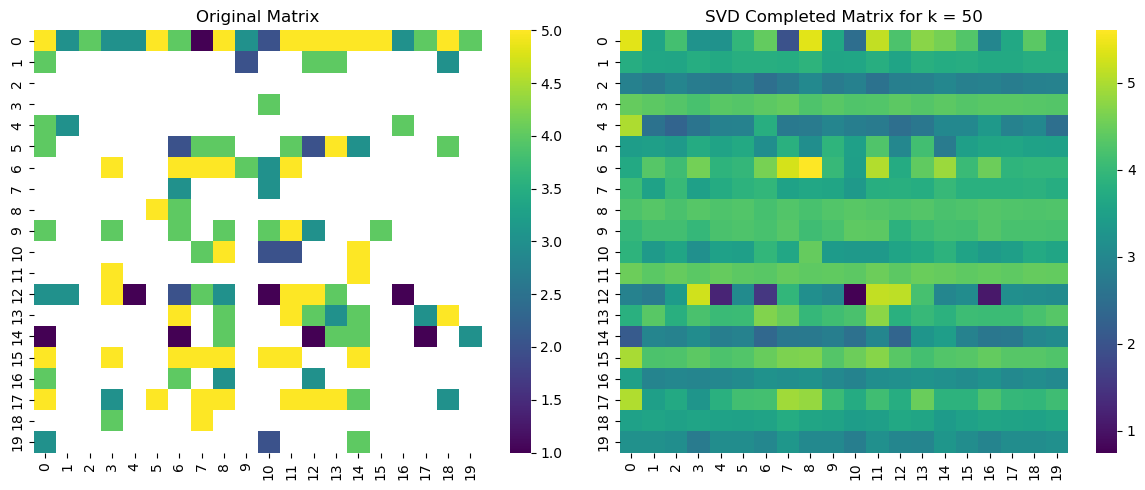

In [22]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(user_item_matrix.values[:20, :20], cmap='viridis')
plt.title("Original Matrix")

plt.subplot(1, 2, 2)
sns.heatmap(svd_pred[:20, :20], cmap='viridis')
plt.title("SVD Completed Matrix for k = 50")
plt.tight_layout()
plt.show()

RMSE for k = 100 is  0.5741163680371183


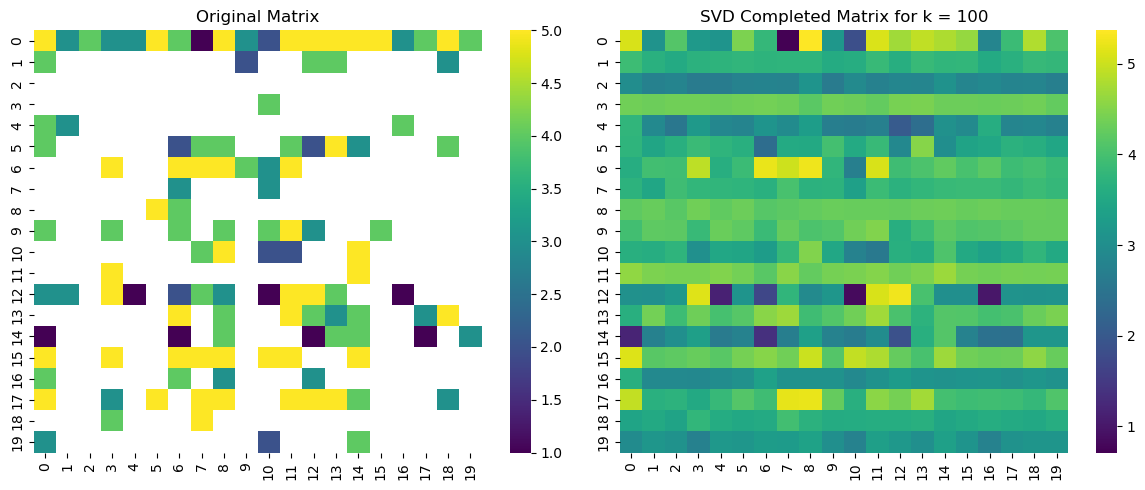

In [23]:
k = 100
svd_pred = matrix_completion(user_item_matrix,k=k)
svd_rmse = compute_svd_rmse(svd_pred ,user_item_matrix)
print(f'RMSE for k = {k} is ',svd_rmse)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(user_item_matrix.values[:20, :20], cmap='viridis')
plt.title("Original Matrix")

plt.subplot(1, 2, 2)
sns.heatmap(svd_pred[:20, :20], cmap='viridis')
plt.title(f'SVD Completed Matrix for k = {k}')
plt.tight_layout()
plt.show()

RMSE for k = 150 is  0.4589927856372623


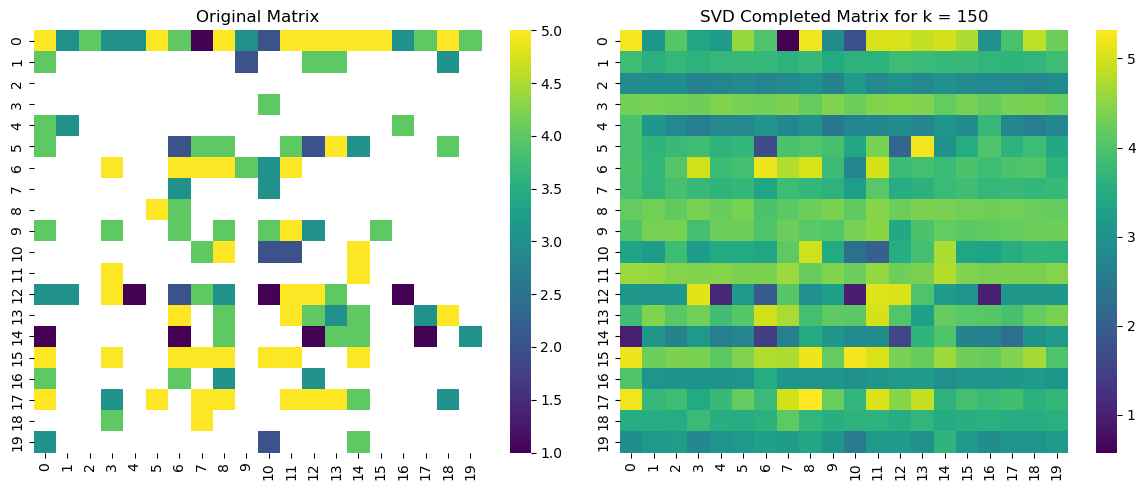

In [24]:
k = 150
svd_pred = matrix_completion(user_item_matrix,k=k)
svd_rmse = compute_svd_rmse(svd_pred ,user_item_matrix)
print(f'RMSE for k = {k} is ',svd_rmse)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(user_item_matrix.values[:20, :20], cmap='viridis')
plt.title("Original Matrix")

plt.subplot(1, 2, 2)
sns.heatmap(svd_pred[:20, :20], cmap='viridis')
plt.title(f'SVD Completed Matrix for k = {k}')
plt.tight_layout()
plt.show()

In [ ]:
# Doing matrix completion using Z-score normalization

def matrix_completion_zscore(R_df, k=20):
    R = R_df.values
    isnan = np.isnan(R)

    # Compute user-wise mean and std on non-NaN entries
    user_mean = np.nanmean(R, axis=1)
    user_std = np.nanstd(R, axis=1)

    # Avoid division by zero in case std is 0
    user_std[user_std == 0] = 1

    # Z-score normalization: (R - mean) / std
    R_zscore = (R - user_mean[:, np.newaxis]) / user_std[:, np.newaxis]
    R_zscore[isnan] = 0  # Replace NaNs with zero for SVD

    # Apply sparse SVD
    U, Sigma, Vt = truncated_svd(R_zscore, k=k)

    # Reconstruct and denormalize
    R_pred_z = U @ Sigma @ Vt
    R_pred = R_pred_z * user_std[:, np.newaxis] + user_mean[:, np.newaxis]
    R_pred = np.clip(R_pred, 1, 5)
    return R_pred

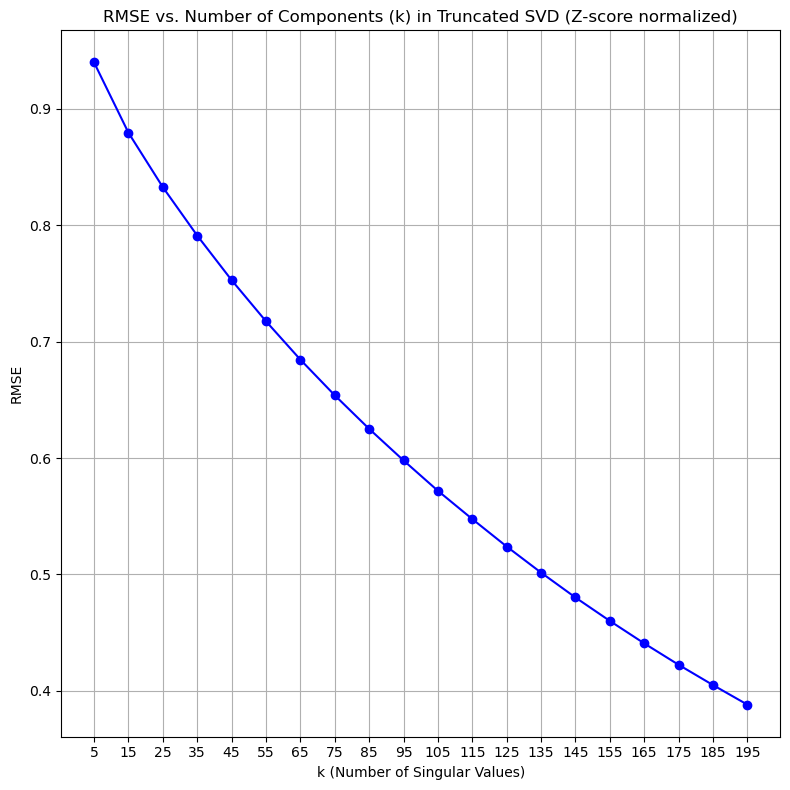

In [26]:
# Now we observe how using z score normalization affect the RMSE score with different k values

rmse_scores = []
k_values = [i for i in range(5,201,10)]
for k in k_values:
    svd_pred = matrix_completion_zscore(user_item_matrix,k=k)
    svd_rmse = compute_svd_rmse(svd_pred,user_item_matrix)
    rmse_scores.append(svd_rmse)


plt.figure(figsize=(8, 8))
plt.plot(k_values, rmse_scores, marker='o', linestyle='-', color='blue')
plt.title('RMSE vs. Number of Components (k) in Truncated SVD (Z-score normalized)')
plt.xlabel('k (Number of Singular Values)')
plt.ylabel('RMSE')
plt.grid(True)
plt.xticks(k_values)
plt.tight_layout()
plt.show()

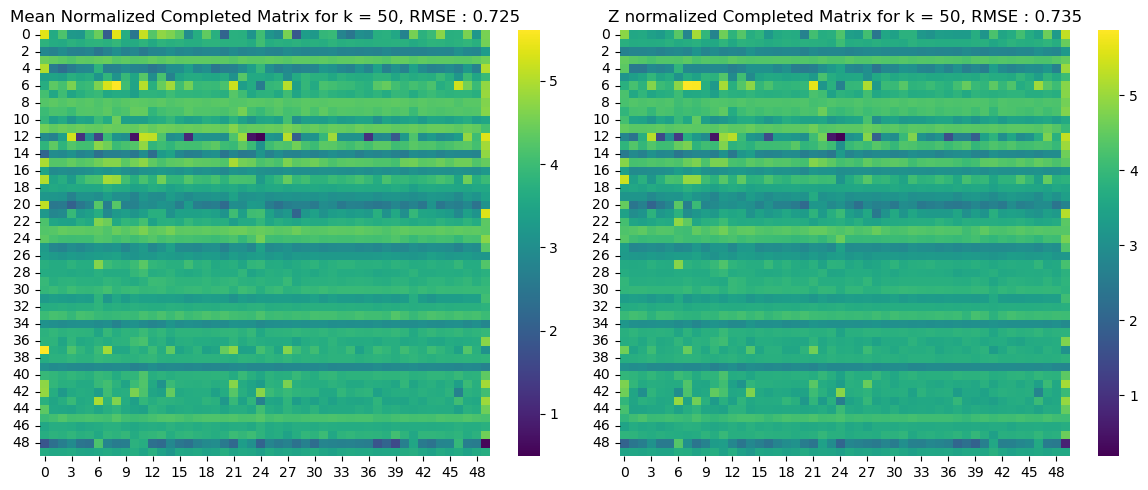

In [27]:
k = 50 
svd_predz = matrix_completion_zscore(user_item_matrix,k=k)
svd_rmse_z = compute_svd_rmse(svd_predz,user_item_matrix)

svd_pred = matrix_completion(user_item_matrix,k=k)
svd_rmse = compute_svd_rmse(svd_pred,user_item_matrix)

svd_predz = matrix_completion_zscore(user_item_matrix,k=k)
svd_rmse_z = compute_svd_rmse(svd_predz,user_item_matrix)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.heatmap(svd_pred[:50, :50], cmap='viridis')
plt.title(f'Mean Normalized Completed Matrix for k = {k}, RMSE : {svd_rmse.round(3)}')

plt.subplot(1, 2, 2)
sns.heatmap(svd_predz[:50, :50], cmap='viridis')
plt.title(f'Z normalized Completed Matrix for k = {k}, RMSE : {svd_rmse_z.round(3)}')
plt.tight_layout()
plt.show()

We observe that the values in the z score normalized completed matrix are lesser extreme since it is immune to the extreme ratings which could be given by the users. However, it will not be able to handle the noisy ratings given by the users.